# Monte Carlo Methods

No more knowledge of the truth of rewards. No more god mode.

Must now learn by interation.

# MC Prediction: State Values

Episodes are a series opf states, actions, rewards, until a terminal state.

Maximise terminal reward!

St for terminal state.

Given a policy pi, estimate value function v_pi from interacting with the environment.

Each occurance of that state is a visit to that state.

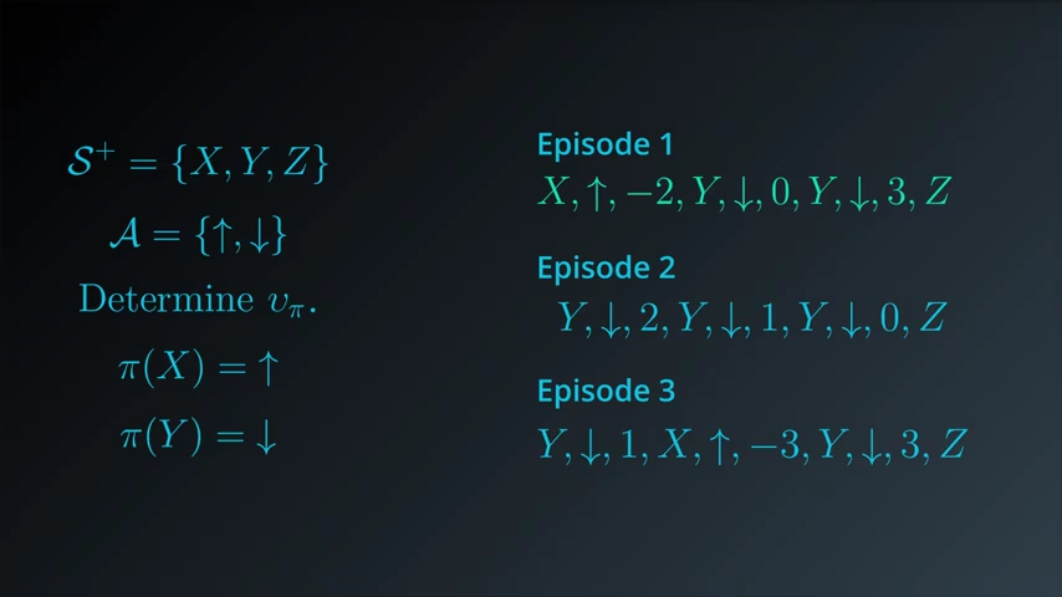

Can evaluate visits using first visit or every visit method.

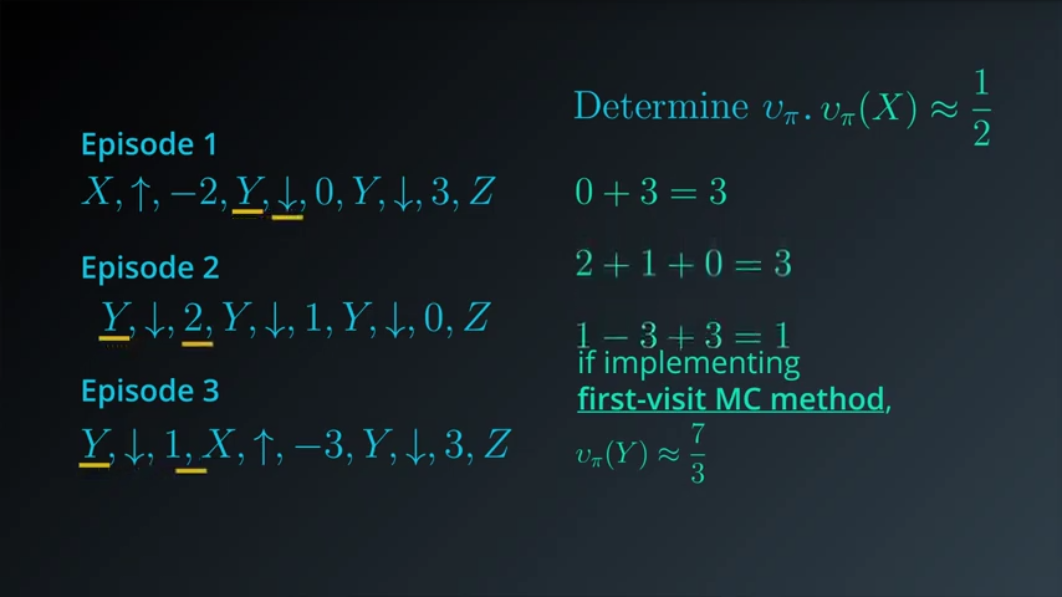

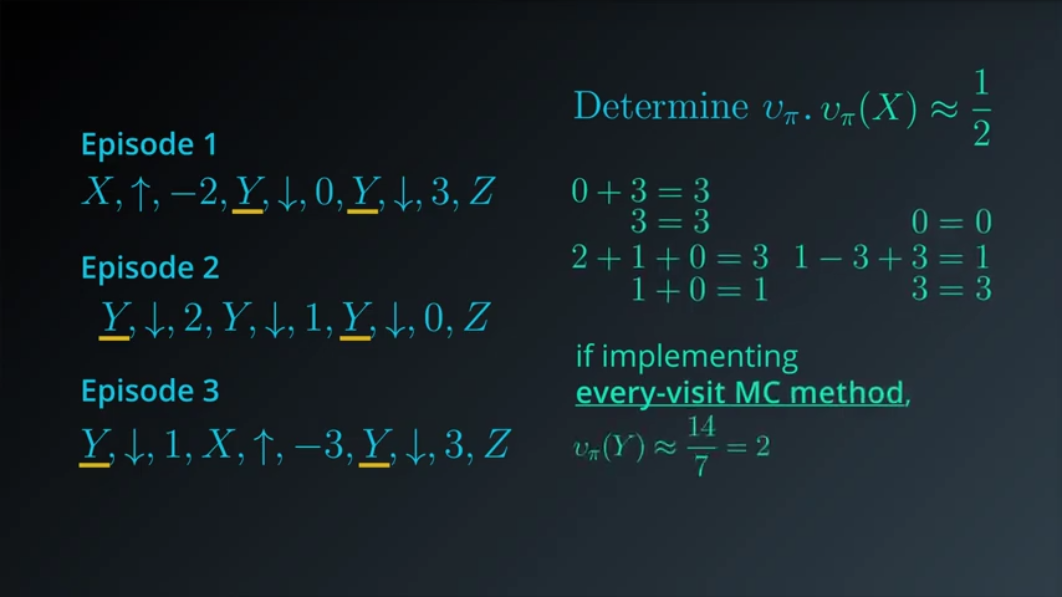

http://www-anw.cs.umass.edu/legacy/pubs/1995_96/singh_s_ML96.pdf

Every-visit MC is biased, whereas first-visit MC is unbiased (see Theorems 6 and 7).

Initially, every-visit MC has lower mean squared error (MSE), but as more episodes are collected, first-visit MC attains better MSE (see Corollary 9a and 10a, and Figure 4).

Both the first-visit and every-visit method are guaranteed to converge to the true value function, as the number of visits to each state approaches infinity. (So, in other words, as long as the agent gets enough experience with each state, the value function estimate will be pretty close to the true value.) In the case of first-visit MC, convergence follows from the Law of Large Numbers, and the details are covered in section 5.1 of the textbook.

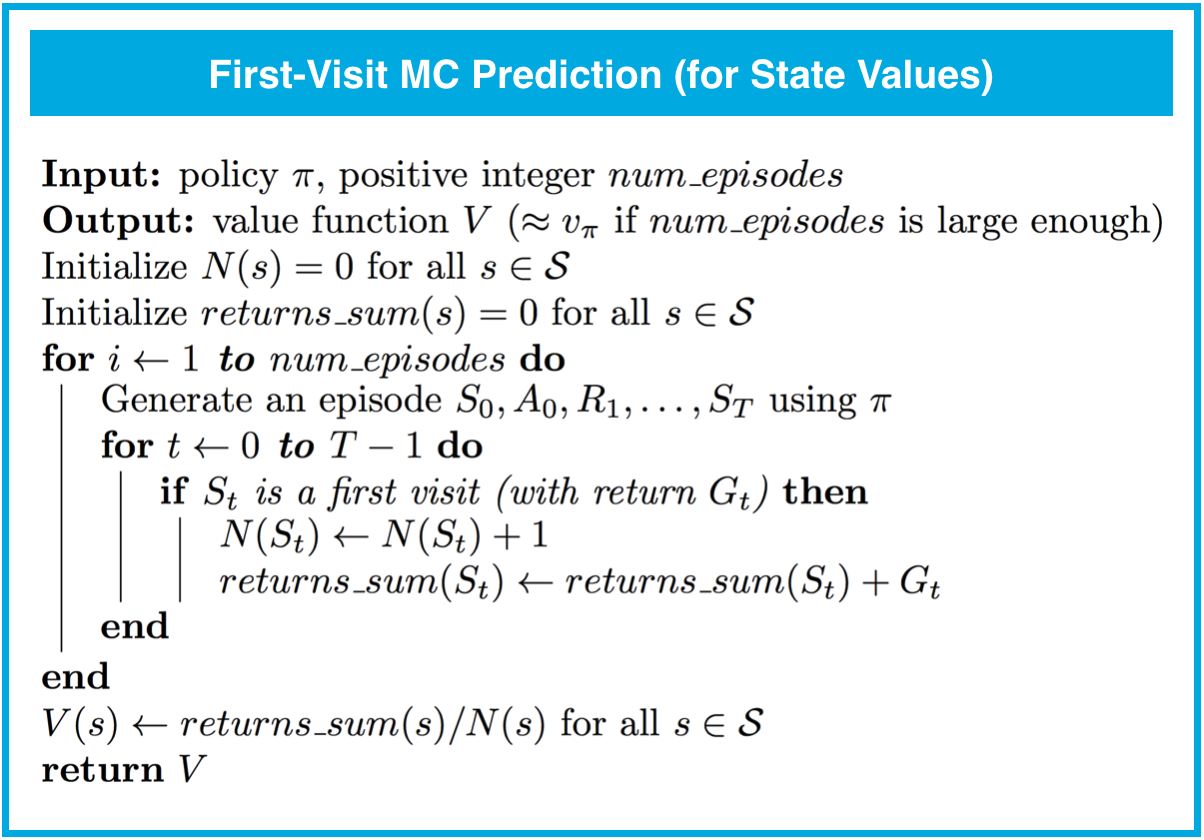


In [1]:
from collections import defaultdict
import numpy as np
import sys

def mc_prediction_v(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionary of lists
    returns = defaultdict(list)
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # calculate and store the return for each visit in the episode
        for i, state in enumerate(states):
            returns[state].append(sum(rewards[i:]*discounts[:-(1+i)]))
    # calculate the state-value function estimate
    V = {k: np.mean(v) for k, v in returns.items()}
    return V

# MC Prediction: Action Values

Look at the visit to each state-action pair instead of each state.

Only work with stochastic policies.

We won't use MC prediction to estimate the action-values corresponding to a deterministic policy; this is because many state-action pairs will never be visited (since a deterministic policy always chooses the same action from each state).

Both the first-visit and every-visit methods are guaranteed to converge to the true value function, as the number of visits to each state-action pair approaches infinity. (So, in other words, as long as the agent gets enough experience with each state-action pair, the value function estimate will be pretty close to the true value.)

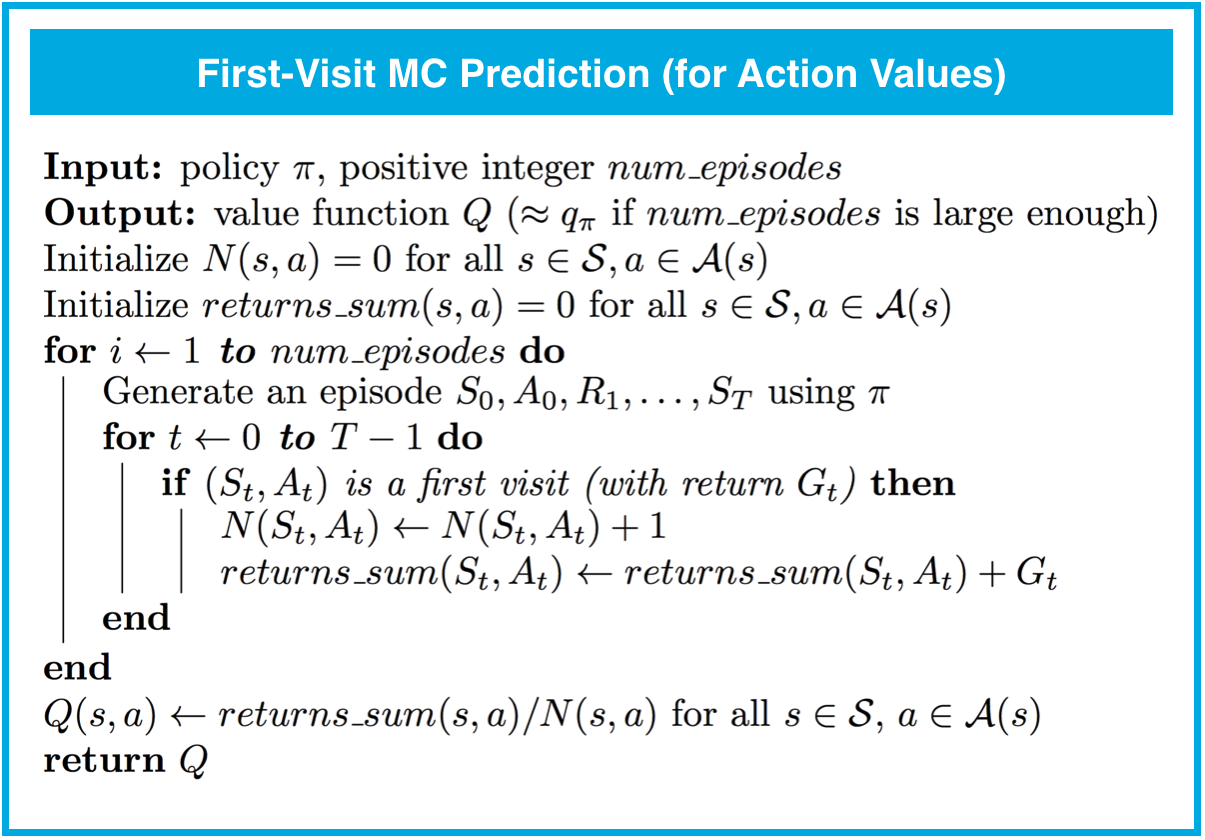



In [2]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):
    # initialize empty dictionaries of arrays
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        # generate an episode
        episode = generate_episode(env)
        # obtain the states, actions, and rewards
        states, actions, rewards = zip(*episode)
        # prepare for discounting
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])
        # update the sum of the returns, number of visits, and action-value 
        # function estimates for each state-action pair in the episode
        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]
    return Q

# Generalized Policy Iteration

The basic algorithmic flow can be summarized as follows:

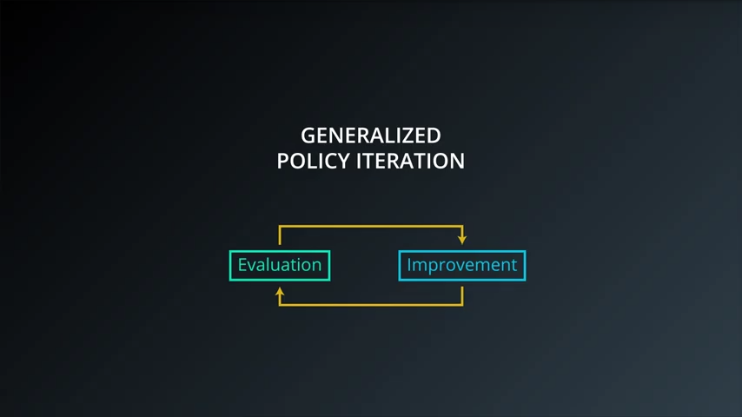

# MC Control: Incremental Mean

Improve the policy after every game, instead of at the end of many games.

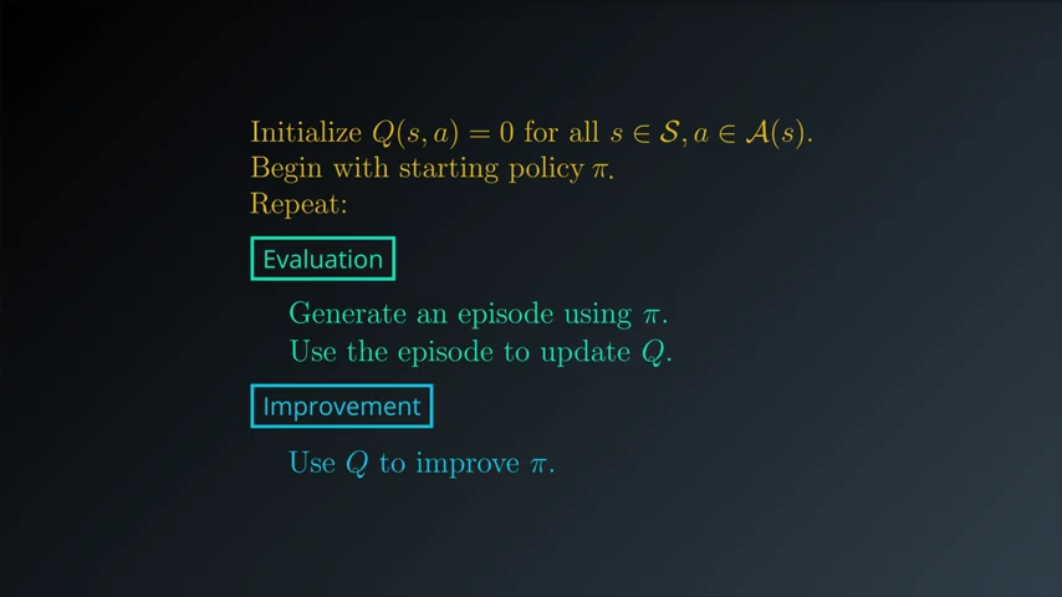

Begin with starting policy, evaluate at the end of each episode, then use the result of the episode to improve the policy (reminds me of gradient decent), then use the new policy for the next episode.

We can estimate the mean state-action value pair

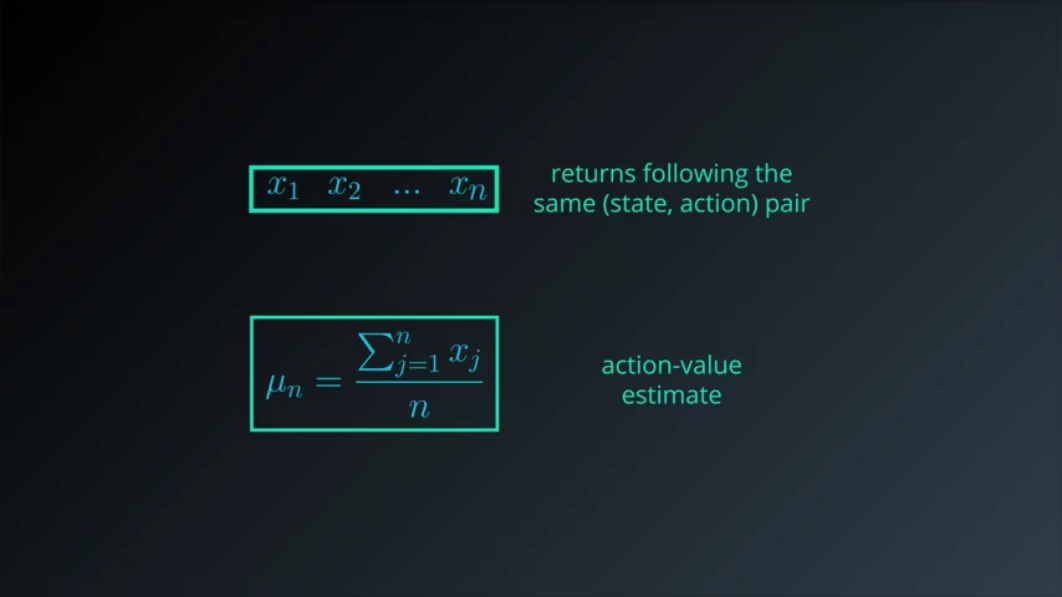

where the mean can be adjusted to be shown as

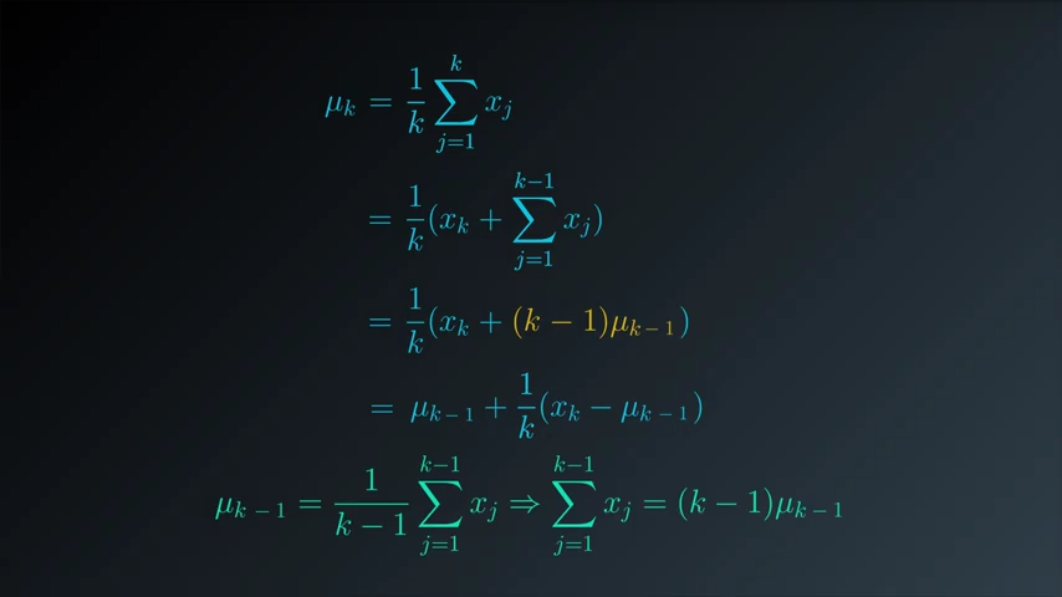

this allows us to update the mean in an incremental way, as an estimate of the true mean, instead of having to compute the whole thing at once.

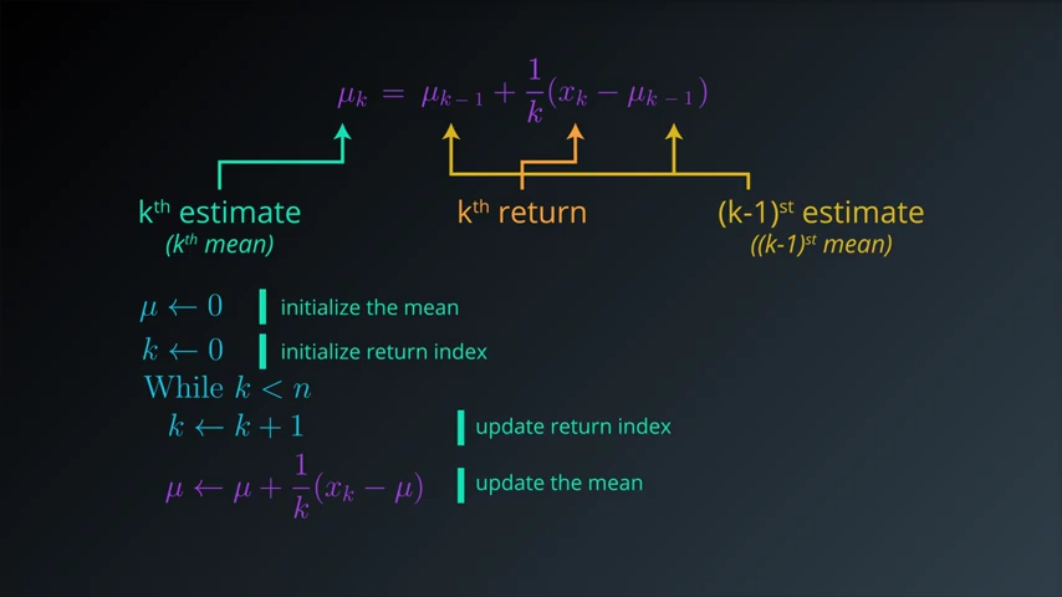



In [4]:
import numpy as np

def running_mean(x):
    mu = 0
    mean_values = []
    for k in np.arange(0, len(x)):
        # TODO: fill in the update step
        k_ind = k # for indexing on the current element
        
        k = k + 1
        mu = mu + (1/(k)) * (x[k_ind] - mu) 
        mean_values.append(mu)
    return mean_values

# MC Control: Policy Evaluation

Mean estimate so farlooks at one state action pair. Can only update a single esitmate. 

Change it to update many state-action pairs.

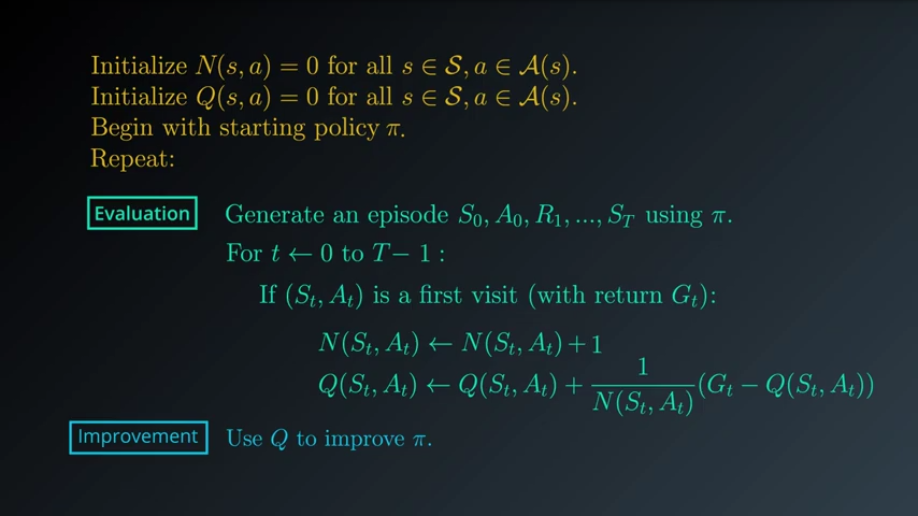


# MC Control: Policy Improvement

Greedy can lead to the case where we always perform the same action, one we have had a positive reward from a single action we will always repeat it. For example:

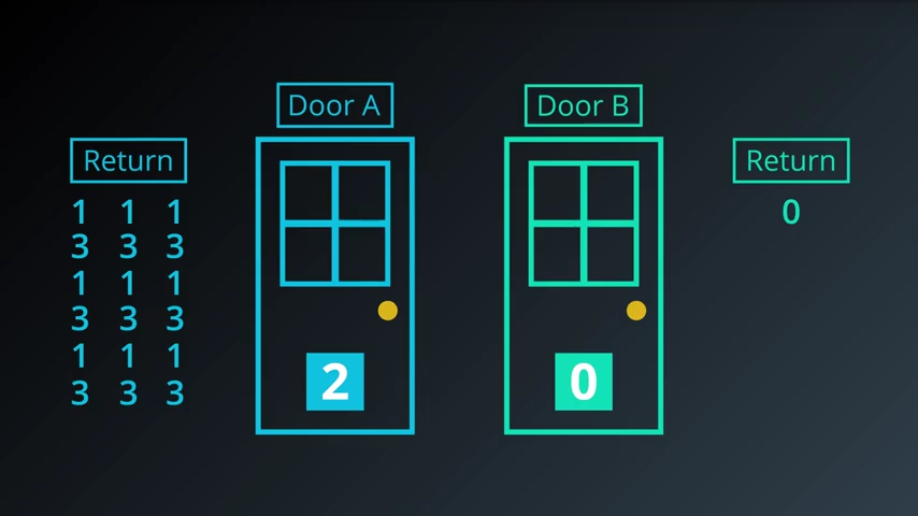

Therefore a stochastic policy is a much safer policy as it will properly sample the action space.

For example we can turn greedy into a stochastic policy 

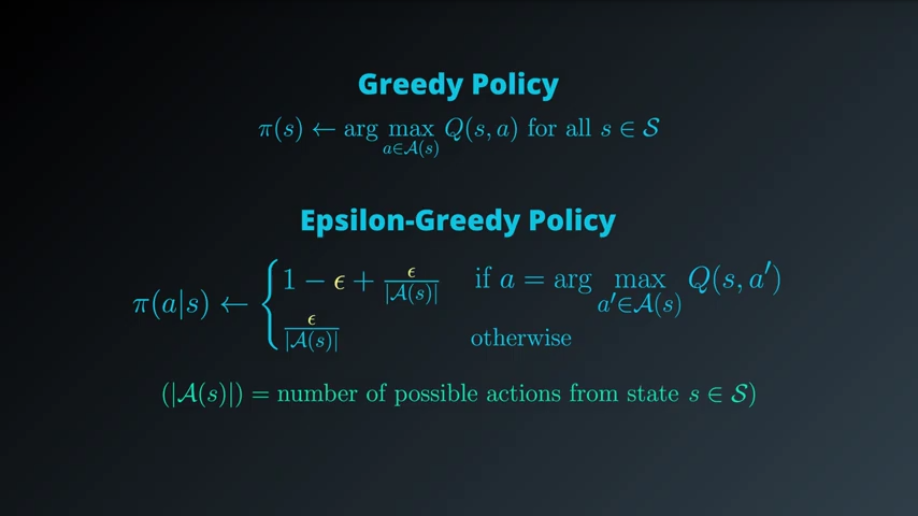

Where episilon greedy can be defined as 

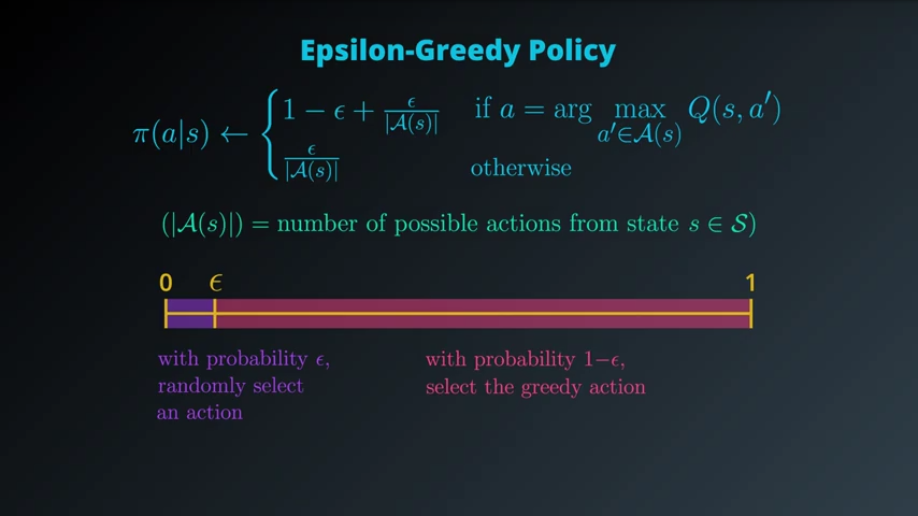

for each s∈Ss and a∈A(s). Note that ϵ must always be a value between 0 and 1, inclusive (that is, ϵ∈[0,1]).

Leading us to the episilon greedy method of polcy improvement

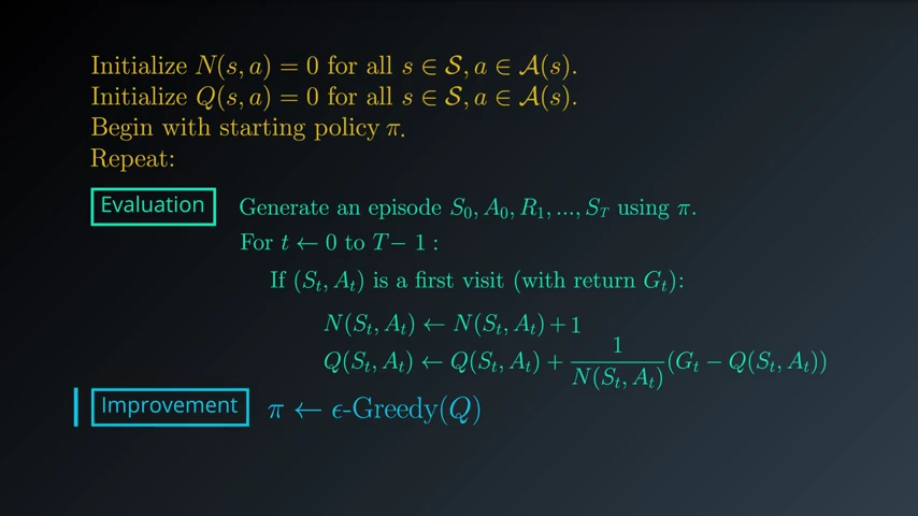

You can think of the agent who follows an ϵ\epsilonϵ-greedy policy as always having a (potentially unfair) coin at its disposal, with probability ϵ\epsilonϵ of landing heads. After observing a state, the agent flips the coin.

* If the coin lands tails (so, with probability 1−ϵ1-\epsilon1−ϵ), the agent selects the greedy action.
* If the coin lands heads (so, with probability ϵ\epsilonϵ), the agent selects an action uniformly at random from the set of available (non-greedy AND greedy) actions.

## Quiz

1. Which of the values for epsilon yields an epsilon-greedy policy that is guaranteed to always select the greedy action? Select all that apply. 

= 0

2. Which of the values for epsilon yields an epsilon-greedy policy that is guaranteed to always select a non-greedy action? Select all that apply.

= Trick question, not possible, as best is a 50/50 selection.

3. Which of the values for epsilon yields an epsilon-greedy policy that is equivalent to the equiprobable random policy (where, from each state, each action is equally likely to be selected)?

= 1

4. Which of the values for epsilon yields an epsilon-greedy policy where the agent has the possibility of selecting a greedy action, but might select a non-greedy action instead? In other words, how might you guarantee that the agent selects each of the available (greedy and non-greedy) actions with nonzero probability?

= any epsilon > 0

## Exploration vs. Exploitation

In many cases, we would like our reinforcement learning (RL) agents to learn to maximize reward as quickly as possible. This can be seen in many OpenAI Gym environments.

For instance, the FrozenLake-v0 environment is considered solved once the agent attains an average reward of 0.78 over 100 consecutive trials.

### THe Dilemma

Recall that the environment's dynamics are initially unknown to the agent. Towards maximizing return, the agent must learn about the environment through interaction.

At every time step, when the agent selects an action, it bases its decision on past experience with the environment. And, towards minimizing the number of episodes needed to solve environments in OpenAI Gym, our first instinct could be to devise a strategy where the agent always selects the action that it believes (based on its past experience) will maximize return. With this in mind, the agent could follow the policy that is greedy with respect to the action-value function estimate. We examined this approach in a previous video and saw that it can easily lead to convergence to a sub-optimal policy.

To see why this is the case, note that in early episodes, the agent's knowledge is quite limited (and potentially flawed). So, it is highly likely that actions estimated to be non-greedy by the agent are in fact better than the estimated greedy action.

With this in mind, a successful RL agent cannot act greedily at every time step (that is, it cannot always exploit its knowledge); instead, in order to discover the optimal policy, it has to continue to refine the estimated return for all state-action pairs (in other words, it has to continue to explore the range of possibilities by visiting every state-action pair). That said, the agent should always act somewhat greedily, towards its goal of maximizing return as quickly as possible. This motivated the idea of an ϵ-greedy policy.

We refer to the need to balance these two competing requirements as the Exploration-Exploitation Dilemma. One potential solution to this dilemma is implemented by gradually modifying the value of ϵ\epsilonϵ when constructing ϵ-greedy policies.

### Setting the Value of Epsilon in Theory

It makes sense for the agent to begin its interaction with the environment by favoring exploration over exploitation. After all, when the agent knows relatively little about the environment's dynamics, it should distrust its limited knowledge and explore, or try out various strategies for maximizing return. With this in mind, the best starting policy is the equiprobable random policy, as it is equally likely to explore all possible actions from each state. You discovered in the previous quiz that setting ϵ=1 yields an ϵ-greedy policy that is equivalent to the equiprobable random policy.

At later time steps, it makes sense to favor exploitation over exploration, where the policy gradually becomes more greedy with respect to the action-value function estimate. After all, the more the agent interacts with the environment, the more it can trust its estimated action-value function. You discovered in the previous quiz that setting ϵ=0 yields the greedy policy (or, the policy that most favors exploitation over exploration).

Thankfully, this strategy (of initially favoring exploration over exploitation, and then gradually preferring exploitation over exploration) can be demonstrated to be optimal. 

### Greedy in the Limit with Inifinite Exploration (GLIE)

In order to guarantee that MC control converges to the optimal policy π∗, we need to ensure that two conditions are met. We refer to these conditions as Greedy in the Limit with Infinite Exploration (GLIE). In particular, if:

* every state-action pair s,as, as,a (for all s∈Ss and a∈A(s) is visited infinitely many times, and
* the policy converges to a policy that is greedy with respect to the action-value function estimate Q,

then MC control is guaranteed to converge to the optimal policy (in the limit as the algorithm is run for infinitely many episodes). These conditions ensure that:

* the agent continues to explore for all time steps, and
* the agent gradually exploits more (and explores less).

One way to satisfy these conditions is to modify the value of ϵ when specifying an ϵ-greedy policy. In particular, let ϵi correspond to the i-th time step. Then, both of these conditions are met if:

* ϵi>0 for all time steps iii, and
* ϵi decays to zero in the limit as the time step i approaches infinity (that is, lim_i→∞ϵi = 0).

For example, to ensure convergence to the optimal policy, we could set ϵi=1/i. (You are encouraged to verify that ϵi>0 for all i, and lim_i→∞ϵi = 0.)

### Setting the Value of Epsilon in Practice

"Guaranteed convergence" isn't good enough in practice, since this really doesn't tell you how long you have to wait! It is possible that you could need trillions of episodes to recover the optimal policy, for instance, and the "guaranteed convergence" would still be accurate! 

Even though convergence is not guaranteed by the mathematics, you can often get better results by either:

* using fixed ϵ, or
* letting ϵi decay to a small positive number, like 0.1.

This is because one has to be very careful with setting the decay rate for ϵ; letting it get too small too fast can be disastrous. If you get late in training and ϵ is really small, you pretty much want the agent to have already converged to the optimal policy, as it will take way too long otherwise for it to test out new actions!

https://storage.googleapis.com/deepmind-media/dqn/DQNNaturePaper.pdf
"The behavior policy during training was epsilon-greedy with epsilon annealed linearly from 1.0 to 0.1 over the first million frames, and fixed at 0.1 thereafter."

## Implementation

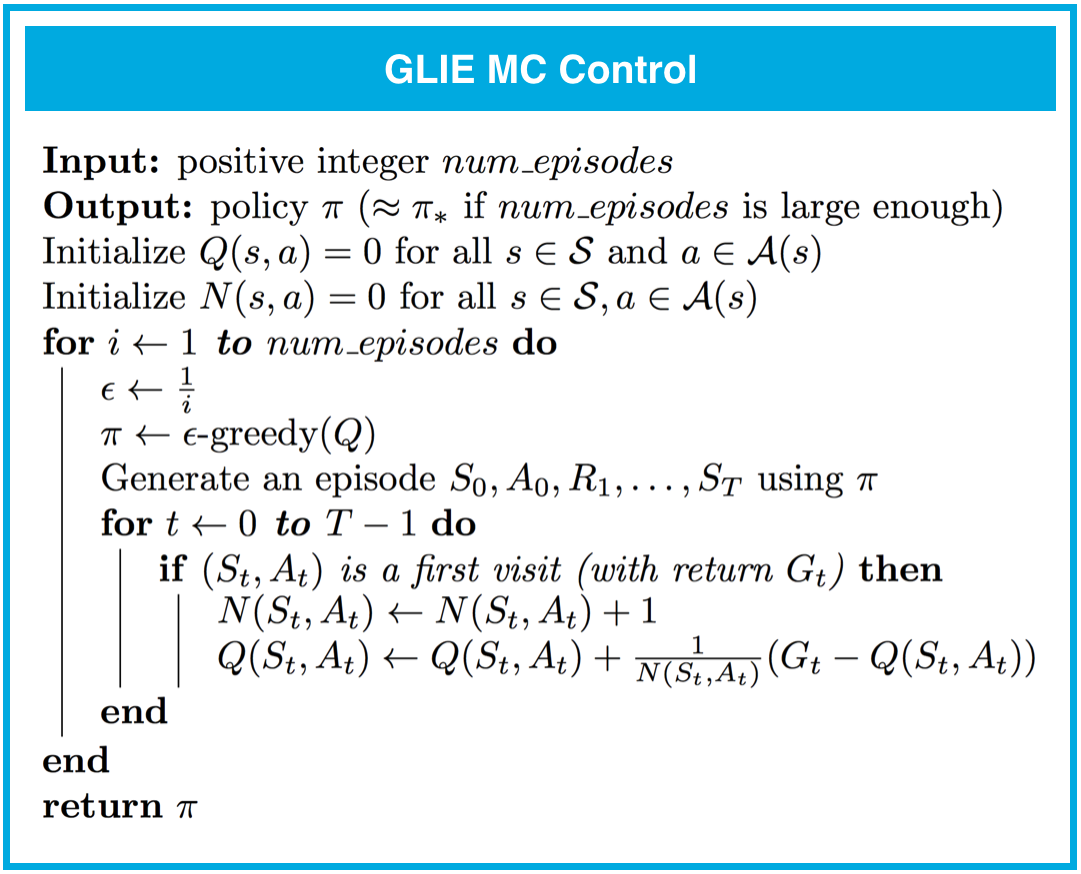


In [5]:
def generate_episode_from_Q(env, Q, epsilon, nA):
    """ generates an episode from following the epsilon-greedy policy """
    episode = []
    state = env.reset()
    while True:
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], epsilon, nA)) \
                                    if state in Q else env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode

def get_probs(Q_s, epsilon, nA):
    """ obtains the action probabilities corresponding to epsilon-greedy policy """
    policy_s = np.ones(nA) * epsilon / nA
    best_a = np.argmax(Q_s)
    policy_s[best_a] = 1 - epsilon + (epsilon / nA)
    return policy_s

def update_Q_GLIE(env, episode, Q, N, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        old_N = N[state][actions[i]]
        Q[state][actions[i]] = old_Q + (sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)/(old_N+1)
        N[state][actions[i]] += 1
    return Q, N


def mc_control_GLIE(env, num_episodes, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionaries of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    N = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        # set the value of epsilon
        epsilon = 1.0/((i_episode/8000)+1)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q, N = update_Q_GLIE(env, episode, Q, N, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    
    return policy, Q

# MC Control: Constant-Alpha

Currently update the actaul value function as follows

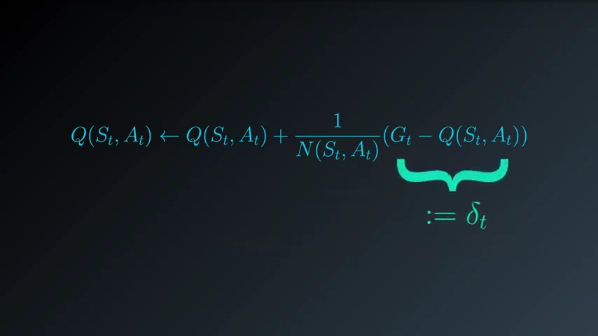

How to improve the update step?

Error term is the delta between expected return vs. what we actually got.

If error > 0, increased Q(S, A)
If error < 0, decrease Q(S, A)

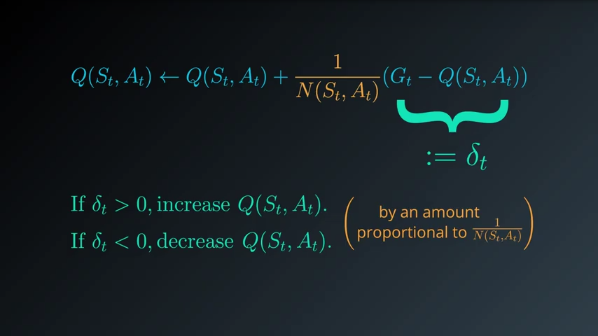

Can use a constant step size to focus on recent results.

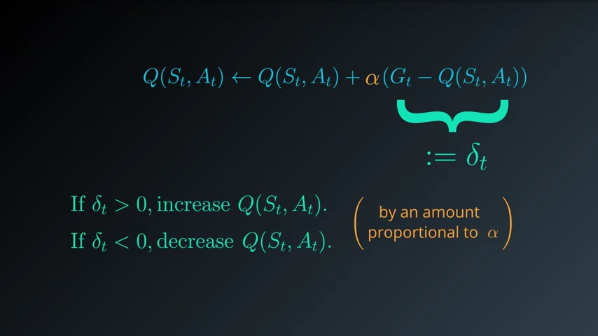

##  Incremental Mean

When we adapted this algorithm for Monte Carlo control in the following concept (MC Control: Policy Evaluation), the sequence (x1,x2,…,xn) corresponded to returns obtained after visiting the same state-action pair.

That said, the sampled returns (for the same state-action pair) likely corresponds to many different policies. This is because the control algorithm proceeds as a sequence of alternating evaluation and improvement steps, where the policy is improved after every episode of interaction. In particular, we discussed that returns sampled at later time steps likely correspond to policies that are more optimal. 

With this in mind, it made sense to amend the policy evaluation step to instead use a constant step size, which we denoted by α\alphaα in the previous video (MC Control: Constant-alpha, Part 1). This ensures that the agent primarily considers the most recently sampled returns when estimating the action-values and gradually forgets about returns in the distant past.

The analogous pseudocode (for taking a forgetful mean of a sequence (x1,x2,…,xn) can be found below.

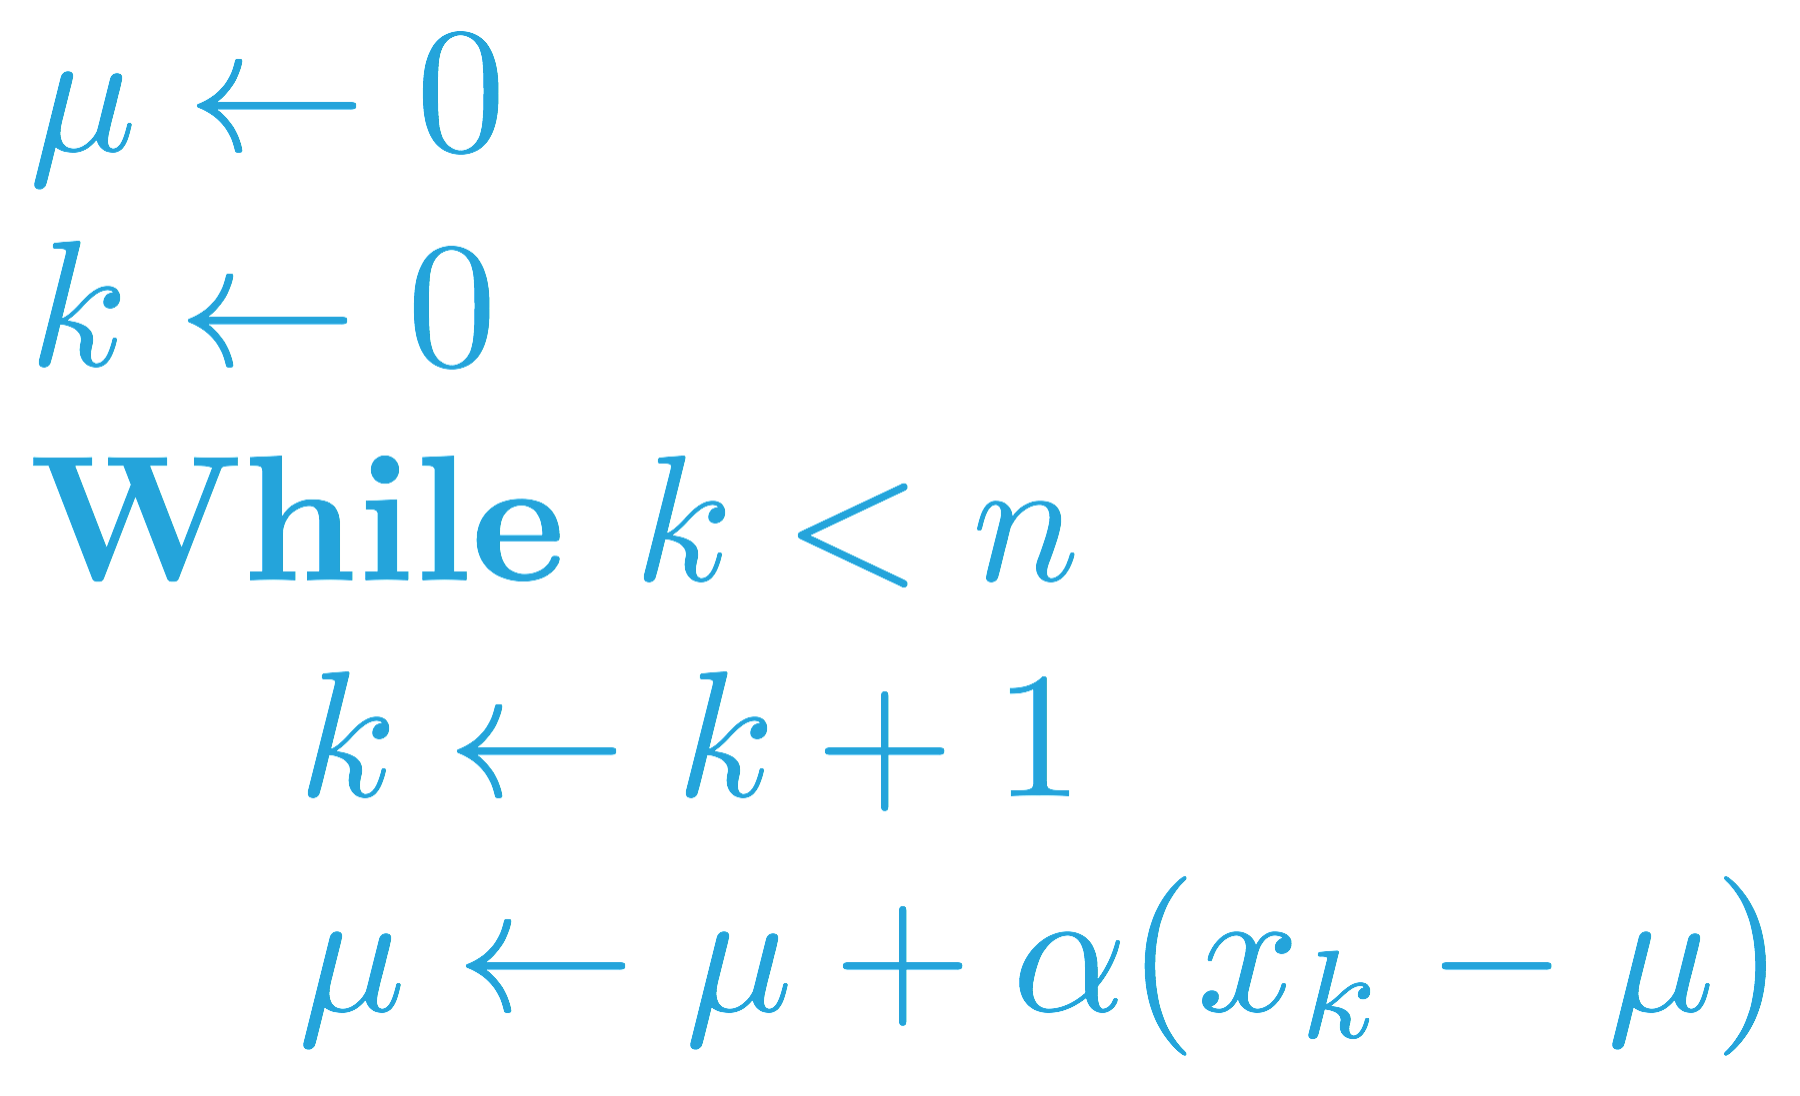


In [10]:
import numpy as np

# This is the sequence (corresponding to successively sampled returns). 
# Feel free to change it!
x = np.hstack((np.ones(10), 10*np.ones(10)))

# These are the different step sizes alpha that we will test.  
# Feel free to change it!
alpha_values = np.arange(0,.9,.01)+.01
print(alpha_values)

#########################################################
# Please do not change any of the code below this line. #
#########################################################

def running_mean(x):
    mu = 0
    mean_values = []
    for k in np.arange(0, len(x)):
        mu = mu + (1.0/(k+1))*(x[k] - mu)
        mean_values.append(mu)
    return mean_values
    
def forgetful_mean(x, alpha):
    mu = 0
    mean_values = []
    for k in np.arange(0, len(x)):
        mu = mu + alpha*(x[k] - mu)
        mean_values.append(mu)
    return mean_values

def print_results():
    """
    prints the mean of the sequence "x" (as calculated by the
    running_mean function), along with analogous results for each value of alpha 
    in "alpha_values" (as calculated by the forgetful_mean function).
    """
    print('The running_mean function returns:', running_mean(x)[-1])
    print('The forgetful_mean function returns:')
    for alpha in alpha_values:
        print(np.round(forgetful_mean(x, alpha)[-1],4), \
        '(alpha={})'.format(np.round(alpha,2)))

print_results()

[0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13 0.14
 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27 0.28
 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41 0.42
 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55 0.56
 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69 0.7
 0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83 0.84
 0.85 0.86 0.87 0.88 0.89 0.9 ]
The running_mean function returns: 5.5
The forgetful_mean function returns:
1.0427 (alpha=0.01)
1.9787 (alpha=0.02)
2.8194 (alpha=0.03)
3.5745 (alpha=0.04)
4.2529 (alpha=0.05)
4.8624 (alpha=0.06)
5.4099 (alpha=0.07)
5.9018 (alpha=0.08)
6.3436 (alpha=0.09)
6.7403 (alpha=0.1)
7.0964 (alpha=0.11)
7.4159 (alpha=0.12)
7.7025 (alpha=0.13)
7.9593 (alpha=0.14)
8.1894 (alpha=0.15)
8.3953 (alpha=0.16)
8.5795 (alpha=0.17)
8.7441 (alpha=0.18)
8.891 (alpha=0.19)
9.0221 (alpha=0.2)
9.1389 (alpha=0.21)
9.2428 (alpha=0.22)
9.3352 (alpha=0.23)
9.4173 (al

* You should always set the value for α\alphaα to a number greater than zero and less than (or equal to) one.
* If α=0, then the action-value function estimate is never updated by the agent.
* If α=1, then the final value estimate for each state-action pair is always equal to the last return that was experienced by the agent (after visiting the pair).
* Smaller values for α\alphaα encourage the agent to consider a longer history of returns when calculating the action-value function estimate. Increasing the value of α\alphaα ensures that the agent focuses more on the most recently sampled returns.

it is also possible to verify the above facts by slightly rewriting the update step as follows:

Q(St​,At​)←(1−α)Q(St​,At​)+αG

where it is now more obvious that α\alphaα controls how much the agent trusts the most recent return GtG_tGt​ over the estimate Q(St,At)Q(S_t,A_t)Q(St​,At​) constructed by considering all past returns.

IMPORTANT NOTE: It is important to mention that when implementing constant-α\alphaα MC control, you must be careful to not set the value of α\alphaα too close to 1. This is because very large values can keep the algorithm from converging to the optimal policy π∗\pi_*π∗​. However, you must also be careful to not set the value of α\alphaα too low, as this can result in an agent who learns too slowly. The best value of α\alphaα for your implementation will greatly depend on your environment and is best gauged through trial-and-error.

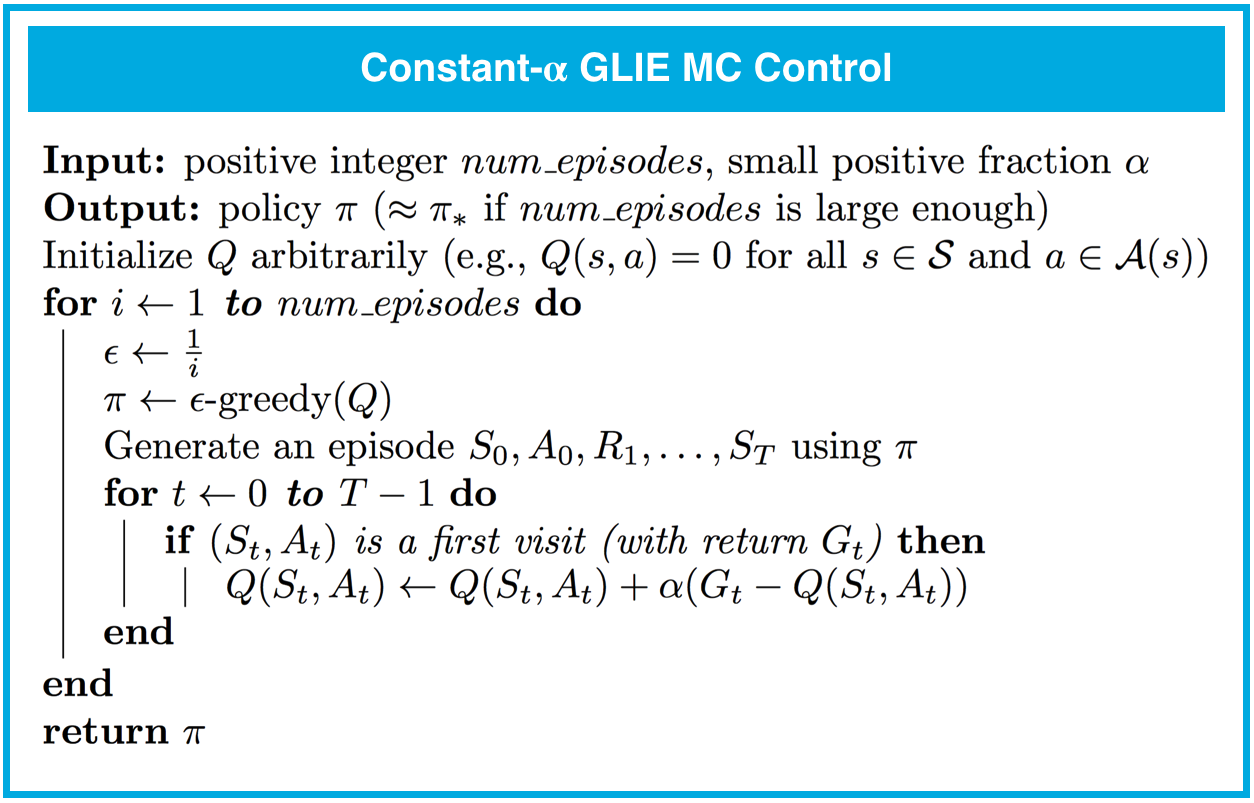



In [13]:
def update_Q_alpha(env, episode, Q, alpha, gamma):
    """ updates the action-value function estimate using the most recent episode """
    states, actions, rewards = zip(*episode)
    # prepare for discounting
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    for i, state in enumerate(states):
        old_Q = Q[state][actions[i]] 
        Q[state][actions[i]] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

def mc_control_alpha(env, num_episodes, alpha, gamma=1.0):
    nA = env.action_space.n
    # initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    # loop over episodes
    for i_episode in range(1, num_episodes+1):
        # monitor progress
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        
        ## TODO: complete the function
        # set the value of epsilon
        epsilon = 1.0/((i_episode/8000)+1)
        # generate an episode by following epsilon-greedy policy
        episode = generate_episode_from_Q(env, Q, epsilon, nA)
        # update the action-value function estimate using the episode
        Q = update_Q_alpha(env, episode, Q, alpha, gamma)
    # determine the policy corresponding to the final action-value function estimate
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
    
    return policy, Q

# Summary

An optimal policy for blackjack can be seen below:

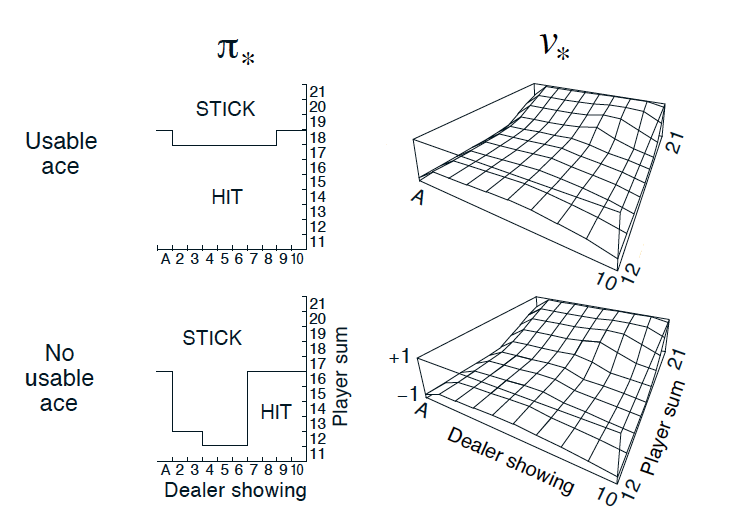

## MC Prediction: State Values

Algorithms that solve the prediction problem determine the value function vπ (or qπ) corresponding to a policy π.
    
Methods that evaluate a policy π from interaction with the environment fall under one of two categories:
* On-policy methods have the agent interact with the environment by following the same policy π that it seeks to evaluate (or improve).
* Off-policy methods have the agent interact with the environment by following a policy b (where b≠π) that is different from the policy that it seeks to evaluate (or improve).
    
Each occurrence of state s∈Ss in an episode is called a visit to state s.
    
There are two types of Monte Carlo (MC) prediction methods (for estimating vπ):
* First-visit MC estimates vπ(s) as the average of the returns following only first visits to s (that is, it ignores returns that are associated to later visits).
* Every-visit MC estimates vπ(s) as the average of the returns following all visits to s.

## MC Prediction: Action Values

Each occurrence of the state-action pair s,a(s∈S,a∈A) in an episode is called a visit to s,a.

There are two types of MC prediction methods (for estimating qπ):
* First-visit MC estimates qπ(s,a) as the average of the returns following only first visits to s,a (that is, it ignores returns that are associated to later visits).
* Every-visit MC estimates qπ(s,a) as the average of the returns following all visits to s,a.

## Generalized Policy Iteration

* Algorithms designed to solve the control problem determine the optimal policy π∗ from interaction with the environment.
* Generalized policy iteration (GPI) refers to the general method of using alternating rounds of policy evaluation and improvement in the search for an optimal policy, All of the reinforcement learning algorithms we examine in this course can be classified as GPI.

## MC Control: Incremental Mean

In this concept, we derived an algorithm that keeps a running average of a sequence of numbers.

## MC Control: Policy Evaluation

In this concept, we amended the policy evaluation step to update the value function after every episode of interaction.

## MC Control: Policy Improvement

A policy is greedy with respect to an action-value function estimate Q if for every state s∈S, it is guaranteed to select an action a∈A(s) such that 

    a = argmax_a∈A(s)Q(s,a( 
    
It is common to refer to the selected action as the greedy action.

A policy is ϵ-greedy with respect to an action-value function estimate Q if for every state s∈Ss,

* with probability 1−ϵ, the agent selects the greedy action, and
* with probability ϵ, the agent selects an action (uniformly) at random.

## Exploration vs. Exploitation

All reinforcement learning agents face the Exploration-Exploitation Dilemma, where they must find a way to balance the drive to behave optimally based on their current knowledge (exploitation) and the need to acquire knowledge to attain better judgment (exploration).

In order for MC control to converge to the optimal policy, the Greedy in the Limit with Infinite Exploration (GLIE) conditions must be met:

* every state-action pair s,a (for all s∈Ss and a∈A(s)) is visited infinitely many times, and
* the policy converges to a policy that is greedy with respect to the action-value function estimate Q.

## MC Control: Constant-Alpha

In this concept, we derived the algorithm for constant-α MC control, which uses a constant step-size parameter α.

The step-size parameter α must satisfy 0<α≤1. Higher values of α will result in faster learning, but values of α that are too high can prevent MC control from converging to π∗.

